# Setup

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import pandas as pd
import numpy as np

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Set max rows and columns displayed in jupyter
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

#the following gives access to utils folder
#where utils package stores shared code
import os
import sys
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.getcwd(),
                  os.pardir)
)

#only add it once
if (PROJECT_ROOT not in sys.path):
    sys.path.append(PROJECT_ROOT)

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Random forest verses regression; which to use when

In <a href="https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-018-2264-5">Random forest versus logistic regression: a large-scale benchmark experiment</a> Couronne et all ran a benchmarking experiment comparing the predictive performence between Random Forest (RF) and Linear Regression (LR) on 243 real datasets. They concluded that <mark>RF performed better than LR according to the considered accuracy measured in approximately 69% of the datasets.</mark>

LR separates data with a linear hyperplane. RF can use non linear criteria.  Or LR uses a flat plane, RF can use both a flat plane, or a bumpy one if that works better. Because of this flexibility Random forest will almost always be a better choice.

Linear regression:
1. Works well when underlying function is linear 
2. Works well when there are a very large number of features
3. Trains fast
4. Overfits unless you have regularization (ridge, LASSO)
5. Need less data than RF to train

Random Forest:
1. Works when underlying function is linear AND non-linear
2. Dont have to spend a lot of time preprocessing data (scale, remove outliers, convert categoricals).  In fact needs very little preprocessing (but it does not hurt to preprocess)
3. In most cases, RF is more accurate than regression

Aother way to look at it: Let’s suppose you are trying to predict income. The predictor variables that are available are education, age, and city. <br>
In a linear regression model, you have an equation with these three attributes. And you’d expect higher degrees of education, higher “age” and larger cities to be associated with higher income.  But what about a PhD who is 40 years old and living in Scranton Pennsylvania? Is he likely to earn more than a BS holder who is 35 and living in Upper West Side NYC? Maybe not. Maybe education totally loses its predictive power in a city like Scranton? Maybe age is a very ineffective, weak variable in a city like NYC?<br>

This is where decision trees are handy. The tree can split by city and you get to use a different set of variables for each city. Maybe Age will be a strong second-level split variable in Scranton, but it might not feature at all in the NYC branch of the tree. Education may be a stronger variable in NYC.

Decision Trees and Random Forest (and soon Gradient Boosted Trees) handle messier data and messier relationships better than regression models. And there is seldom a dataset in the real world where relationships are not messy. For this reason you will seldom see a linear regression model outperforming RF.



# One case where LR is better than RF - The RF extrapoltaion problem
When RF sees data that is outside the range of what it has been trained on, it will pick its highest value (or lowest).  LR regression handles this case just fine.  <br>
Note:  The following example comes from Jeremy Howards excellent <a href="https://course.fast.ai/">Practical Deep Learning for Coders</a> course 

## Generate Data, the middle 800 points are used for training, the first and last 100 points represent data whose magnitude will not be seen by the model during training

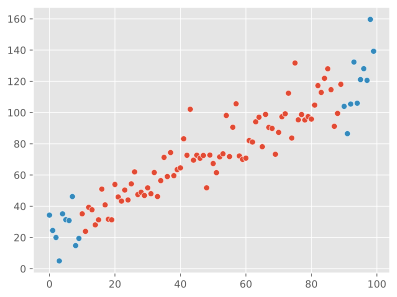

In [19]:
import random
import utils as ut
random.seed(a=ut.RANDOM_SEED)#ensures repeatability

x,y = ut.gendata(ut.NUMB_SAMPLES)

#lets split it.  Note that I'm NOT using traintestsplit since I want data  
# ranges that neither the LR or RF model has seen before

x_train = x[10:-10]
x_test = np.concatenate([x[:10], x[ut.NUMB_SAMPLES-10:]])

y_train = y[10:-10]
y_test = np.concatenate([y[:10], y[ut.NUMB_SAMPLES-10:]])

#see what it looks like, note the blue points, those will be data the rf has never seen
#squeeze converts from [NUMB_SAMPLES,1] to [NUMB_SAMPLES].  It squeezes out the extra dimension
_=sns.scatterplot(x=x_train.squeeze(),y=y_train.squeeze())
_=sns.scatterplot(x=x_test.squeeze(),y=y_test.squeeze())

## Linear regression

In [20]:
x_train=x_train.reshape(-1,1)

In [21]:
#lets see what a linear model looks like
from sklearn import linear_model
reg = linear_model.LinearRegression()

#squeeze converts from [NUMB_SAMPLES,1] to [NUMB_SAMPLES].  It squeezes out the extra dimension
_=reg.fit(X=x_train, y=y_train.squeeze())

### Note that it handles the extrapolated data quite well
The blue points below are its predictions for the green extrapolated points

In [22]:
y=reg.predict(x_test.reshape(-1,1))
y.shape

(20,)

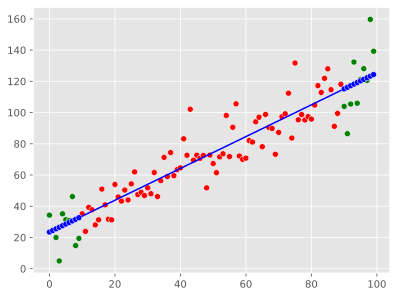

In [23]:
#plot points and linear regression line
_=sns.scatterplot(x=x_train.squeeze(), y=y_train.squeeze(),color='red')
_=sns.scatterplot(x=x_test.squeeze(), y=y_test.squeeze(), color='green')
_=sns.scatterplot(x=x_test.squeeze(), y=reg.predict(x_test.reshape(-1,1)).squeeze(),color='blue' )
_=sns.lineplot(x=x_train.squeeze(), y=reg.predict(x_train.reshape(-1,1)).squeeze(),color='blue' )

## Random Forest regression

In [24]:
#Note I am using just 1 estimator (basically a Decision tree)

#lets see what a random forest regressor model looks like
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()

#squeeze converts from [NUMB_SAMPLES,1] to [NUMB_SAMPLES].  It squeezes out the extra dimension
_=rf_reg.fit(X=x_train, y=y_train.squeeze())

Lets have a look at that single decision tree, note the highest value predicted (the right most split, child leaf that is greater than) and the lowest (left most split child that is less than)
These are the maximum and minimum that the tree will ever predict

In [25]:
#here is the first random forest estimator
rf_reg.estimators_[0]

DecisionTreeRegressor(max_features=1.0, random_state=779006395)

<Figure size 3200x2200 with 0 Axes>

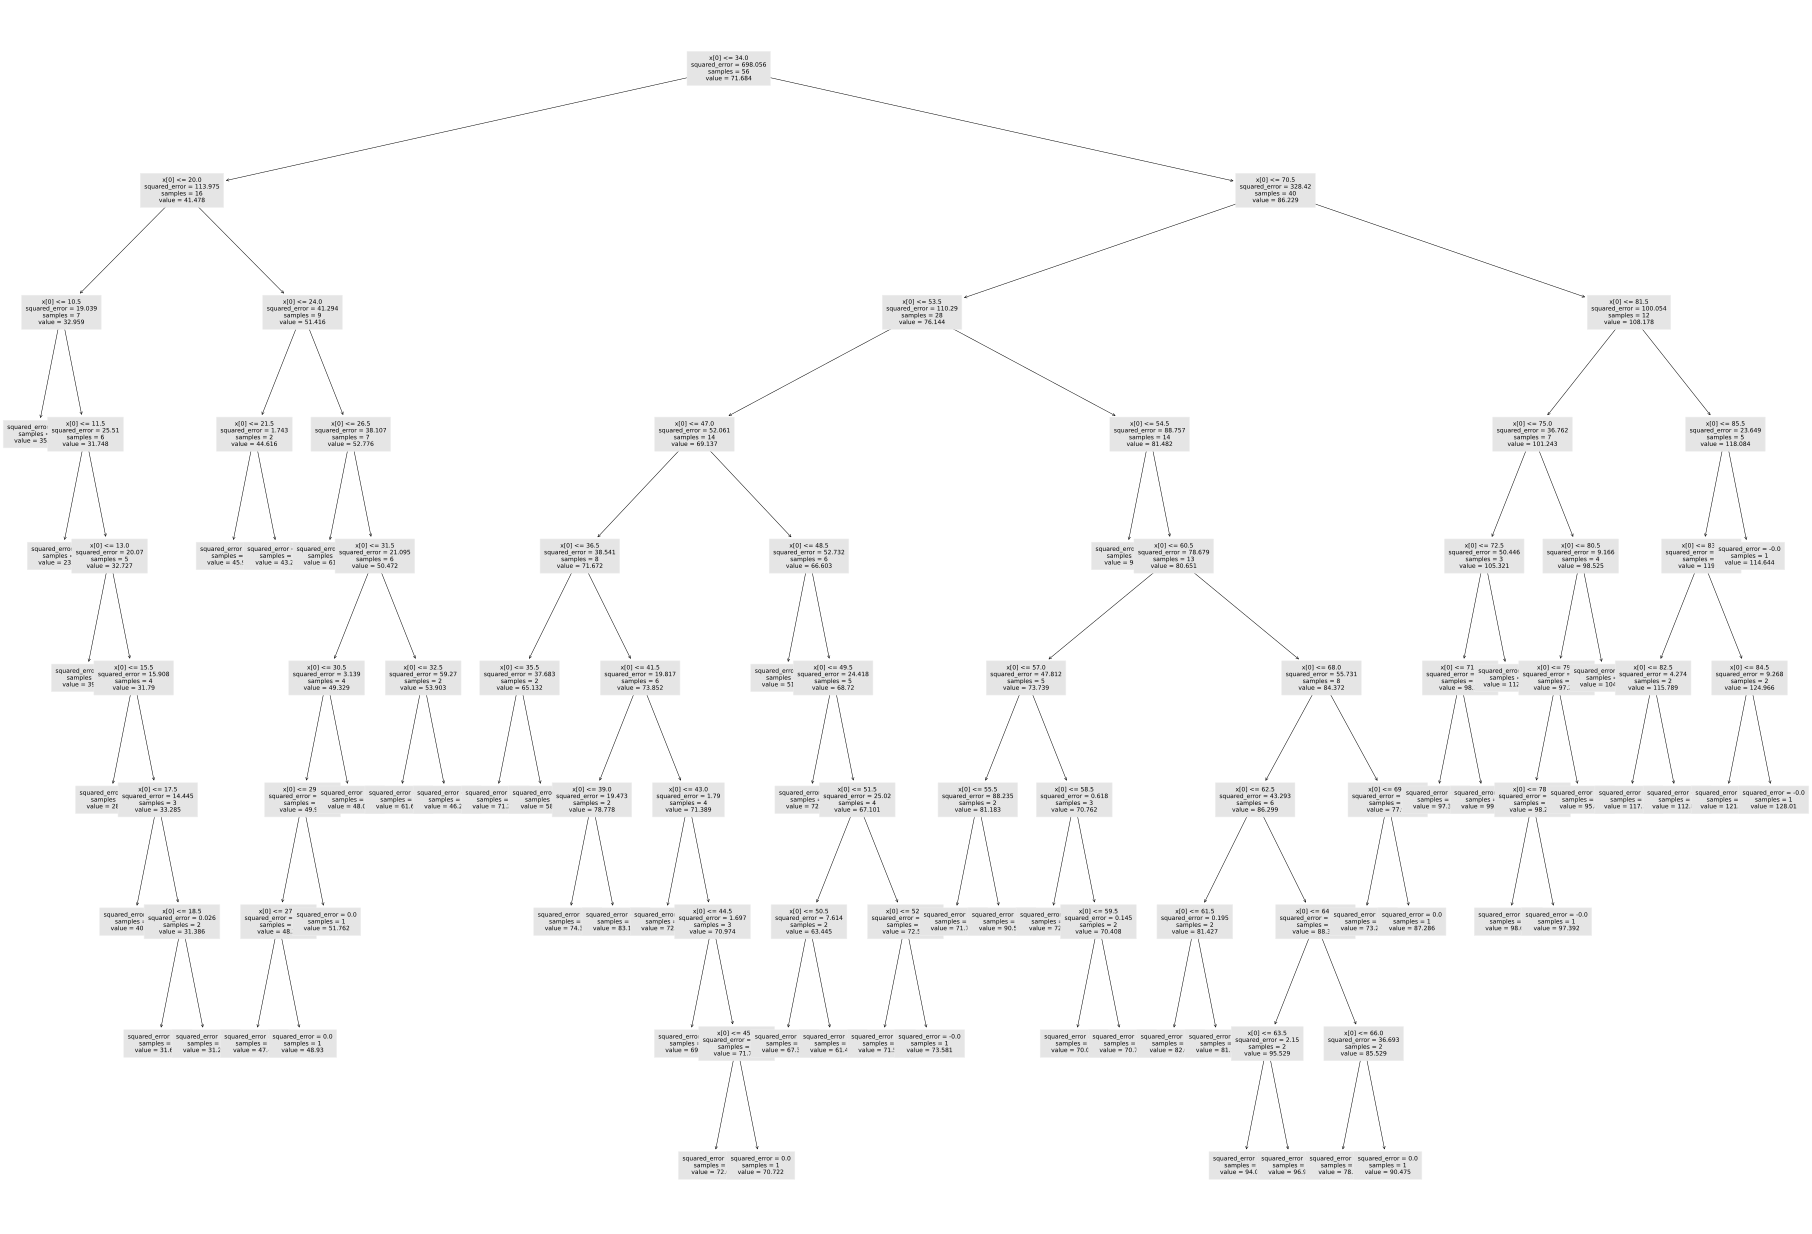

In [15]:
#and here is a plot of that tree
from sklearn import tree
plt.figure(figsize=(32,22))
_=tree.plot_tree(rf_reg.estimators_[0], fontsize=6)  #returns the annotations, if you dont capture this (_=...) then they are printed
plt.savefig('tree_high_dpi', dpi=100)

In [16]:
rf_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Note that it DOES NOT handle the extrapolated data quite well
The blue points below are its predictions for the green extrapolated points.  <mark> Note the plateau at both the lower and upper end.  This is beacuse the random forest is estimating it's min and max values

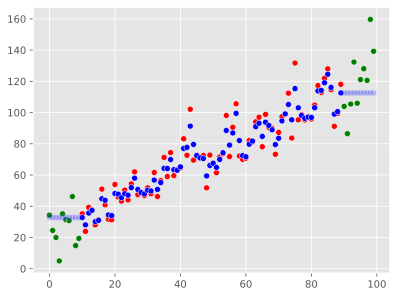

In [26]:
#plot points and extrapolated data
_=sns.scatterplot(x=x_train.squeeze(), y=y_train.squeeze(),color='red')
_=sns.scatterplot(x=x_train.squeeze(), y=rf_reg.predict(x_train.reshape(-1,1)).squeeze(),color='blue' )
_=sns.scatterplot(x=x_test.squeeze(), y=y_test.squeeze(), color='green')
_=sns.scatterplot(x=x_test.squeeze(), y=rf_reg.predict(x_test.reshape(-1,1)).squeeze(),color='blue', alpha=0.2 )

## RF and extrapolation summary
When the Random Forest Regressor tries predicting values not previously seen, it will always predict an average of the values seen previously. Obviously the average of a sample can not fall outside the highest and lowest values in the sample. SO it plateus at the max or the min.